# Transform Experiments

custom transforms

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from PIL import Image as pil_image

In [3]:
#pip3 install nvidia-ml-py3
import tracemalloc, threading, torch, time, pynvml
from fastai.utils.mem import *
from fastai.vision import *

In [4]:
import fastai
print(fastai.__version__)

1.0.43.dev0


In [5]:
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
#see https://forums.fast.ai/t/gpu-optimizations-central/33944/15
#"memory profiler that taps into each epoch, and can be fine-tuned to each separate stage"
if not torch.cuda.is_available(): raise Exception("pytorch is required")

def preload_pytorch():
    torch.ones((1, 1)).cuda()
    
def gpu_mem_get_used_no_cache():
    torch.cuda.empty_cache()
    return gpu_mem_get().used

def gpu_mem_used_get_fast(gpu_handle):
    info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
    return int(info.used/2**20)

preload_pytorch()
pynvml.nvmlInit()

class PeakMemMetric(LearnerCallback):
    _order=-20 # Needs to run before the recorder

    def peak_monitor_start(self):
        self.peak_monitoring = True

In [7]:
path = Path('../data/mnist/mnist_png')

In [8]:
np.random.seed(42)

### No transforms

In [9]:
#no transforms
tfms = get_transforms(do_flip=False, 
                      flip_vert=False, 
                      max_rotate=0., 
                      max_zoom=0., 
                      max_lighting=0., 
                      max_warp=0., 
                      p_affine=0., 
                      p_lighting=0.)


In [10]:
data = ImageDataBunch.from_folder(path, valid_pct = 0.2,ds_tfms=tfms, size=28)

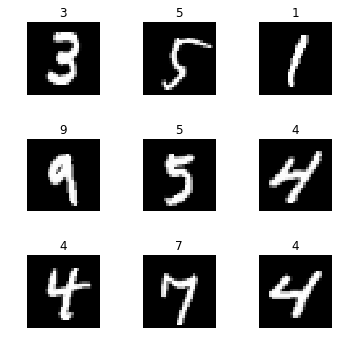

In [11]:
data.show_batch(rows=3, figsize=(5,5))

### fit

In [12]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)

self._lr: [slice(None, 0.003, None), slice(None, 0.003, None), slice(None, 0.003, None)]
self._lr: [slice(None, 0.003, None), slice(None, 0.003, None), slice(None, 0.003, None)]


Defaults for lr_find:
    
lr_find(learn:Learner, start_lr:Floats=1e-7, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, **kwargs:Any):

NB in lr_find we call Learner.fit()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


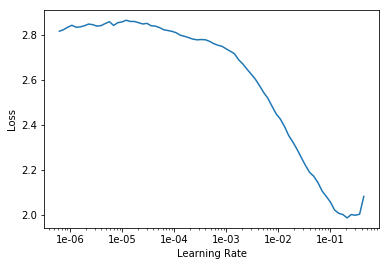

In [15]:
learn.lr_find()
learn.recorder.plot(skip_start=10, skip_end=5)


### Defaults

In defaults the default lr in fastai is:
    
    slice(None, 3e-3, None)
    
This is the lr that is set *if lr_find() has not been called*:

    lr: slice(None, 0.003, None)

which is then set to (in this case there are 3 layer goups):
    
    lr = np.array([lr.stop/10]*(len(self.layer_groups)-1) + [lr.stop])
    
and set for this callback
    
    OptimWrapper._lr: [0.0003, 0.0003, 0.003]
    

Default weight decay:

    wd = 0.01

In [13]:
learn.fit(2)

lr: slice(None, 0.003, None), type: <class 'slice'>, defaults.lr: slice(None, 0.003, None)
self._lr: [0.00030000000000000003, 0.00030000000000000003, 0.003]


epoch,train_loss,valid_loss,error_rate
1,0.344157,0.221896,0.069500
2,0.200844,0.126944,0.038071


### fit one cycle

JH: As a rule of thumb, for top learning, use 1e-4 or 3e-4

In [17]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


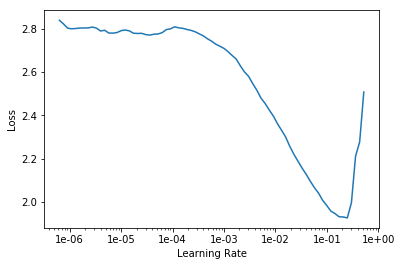

In [18]:
learn.lr_find()
learn.recorder.plot(skip_start=10, skip_end=5)

Default parameters for fit_one_cycle:

fit_one_cycle(learn:Learner, cyc_len:int, max_lr:Union[Floats,slice]=defaults.lr,
                  moms:Tuple[float,float]=(0.95,0.85), div_factor:float=25., pct_start:float=0.3,
                  wd:float=None, callbacks:Optional[CallbackList]=None, **kwargs)
                  
In code below where we have start_lr of 3e-5 and stop_lr of 3e-4,
the lr_range is distributed accoss the n layer_grougs.

Here we have 3 layer goups, and the lr_range is set to:

[3e-05 9.49e-05 3e-04]

In [19]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate
1,0.866574,0.639191,0.205143
2,0.695715,0.527216,0.167429


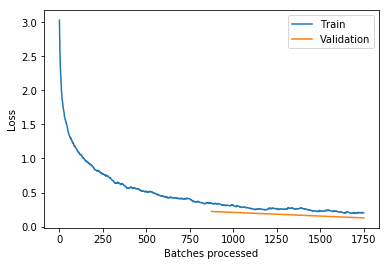

In [14]:
learn.recorder.plot_losses()

In above we see validation loss is lower than training loss:
    
Either:
    
    learning rate is too small 
    
    number of epochs is too low
    
    model is too simple

## Unfreeze

JH: take whatever did last time and divide it by 5 or 10
    
So if used 3e-3 for initial fit, then use

slice(steepest slope or 10x smaller than bottom , lr/10)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(xxx, 3e-4))